<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TERM2/ML_Lab/Project/industrial-ai-project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Soumya Mukherjee  | CH24M571 | Project

In [108]:
%pip install imbalanced-learn catboost xgboost category_encoders lightgbm

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from category_encoders import LeaveOneOutEncoder,TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import log_loss

warnings.filterwarnings('ignore')

In [110]:
raw_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

raw_data = raw_data.drop(['id'],axis=1)
test_data = test_data.drop(['id'],axis=1)

raw_data.shape , test_data.shape

((15000, 19), (10000, 18))

id: This column likely represents a unique identifier for each patient or observation in the dataset.

N_Days: This column represents the number of days for which the data was collected or observed for each patient.

Drug: This column likely represents the type of drug or treatment that the patient was given.

Age: This column represents the age of the patient.

Sex: This column represents the sex of the patient,
typically coded as 0 for female and 1 for male.

Ascites: This column represents the presence or absence of ascites, which is the accumulation of fluid in the abdominal cavity. It is likely coded as 0 for absent and 1 for present.

Hepatomegaly: This column represents the presence or absence of hepatomegaly, which is the enlargement of the liver. It is likely coded as 0 for absent and 1 for present.

Spiders: This column represents the presence or absence of spider angiomas, which are small blood vessels that appear on the skin. It is likely coded as 0 for absent and 1 for present.

Edema: This column represents the presence or absence of edema, which is the swelling of tissues due to the accumulation of fluid. It is likely coded as 0 for absent and 1 for present.

Bilirubin: This column represents the level of bilirubin in the patient's blood, which is a measure of liver function.

Cholesterol: This column represents the level of cholesterol in the patient's blood.

Albumin: This column represents the level of albumin in the patient's blood, which is a measure of liver function.

Copper: This column represents the level of copper in the patient's blood.

Alk_Phos: This column represents the level of alkaline phosphatase in the patient's blood, which is a measure of liver function.

SGOT: This column represents the level of serum glutamic-oxaloacetic transaminase in the patient's blood, which is a measure of liver function.

Tryglicerides: This column represents the level of triglycerides in the patient's blood.

Platelets: This column represents the number of platelets in the patient's blood.

Prothrombin: This column represents the prothrombin time, which is a measure of the time it takes for the blood to clot.

Stage: This column likely represents the stage or severity of the patient's liver disease.

Status: This column likely represents the outcome or status of the patient, such as alive or dead.


In [111]:
numerical_cols = raw_data.select_dtypes(include=['number']).columns
categorical_cols = raw_data.select_dtypes(exclude=['number']).columns

print(f'Numerical Columns are : {numerical_cols}','\n')
print(f'Categorical Columns are : {categorical_cols}','\n')

Numerical Columns are : Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object') 

Categorical Columns are : Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status'], dtype='object') 



In [112]:
def draw_class_balance_pie_chart(processable_data):
  status_counts = processable_data['Status'].value_counts()

  # pie chart
  plt.figure(figsize=(8, 8))
  plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
  plt.title('Class Distribution of Status')
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.show()

In [113]:
# # finding unique values in each columns


unique_test = pd.DataFrame({
    'Column': test_data.columns,
    'Test Unique': [test_data[col].nunique() for col in test_data.columns]
})

unique_raw = pd.DataFrame({
    'Column': raw_data.columns,
    'Train Unique': [raw_data[col].nunique() for col in raw_data.columns]
})

# Merging the two tables on 'Column' - this is similar to SQL joins
unique_combined = pd.merge(unique_raw, unique_test, on='Column', how='outer')

print("Unique value counts for train and test data side by side:")
print(unique_combined)


Unique value counts for train and test data side by side:
           Column  Train Unique  Test Unique
0             Age           384        374.0
1         Albumin           164        164.0
2        Alk_Phos           382        350.0
3         Ascites             2          2.0
4       Bilirubin           116        115.0
5     Cholesterol           212        208.0
6          Copper           175        165.0
7            Drug             3          2.0
8           Edema             3          3.0
9    Hepatomegaly             2          2.0
10         N_Days           552        510.0
11      Platelets           262        255.0
12    Prothrombin            50         52.0
13           SGOT           202        195.0
14            Sex             2          2.0
15        Spiders             2          2.0
16          Stage             4          4.0
17         Status             3          NaN
18  Tryglicerides           153        152.0


In [114]:
processable_data = raw_data.copy(deep=True)
print(processable_data.shape)

td_copy = test_data.copy(deep = True)
print(td_copy.shape)

(15000, 19)
(10000, 18)


In [115]:
# finding the percentage of missing values


missing_train = raw_data.isnull().sum()
missing_test = test_data.isnull().sum()

missing_train_df = pd.DataFrame({'Column': missing_train.index, 'Missing Count': missing_train.values})
missing_test_df = pd.DataFrame({'Column': missing_test.index, 'Missing Count': missing_test.values})
percentage_missing_train_df = pd.DataFrame({'Column': missing_train.index, 'Percentage Missing': (missing_train.values / len(raw_data)) * 100})
percentage_missing_test_df = pd.DataFrame({'Column': missing_test.index, 'Percentage Missing': (missing_test.values / len(test_data)) * 100})


comparison_df = pd.merge(missing_train_df, missing_test_df, on='Column', suffixes=('_train', '_test'))
comparison_df = pd.merge(comparison_df, percentage_missing_train_df, on='Column')
comparison_df = pd.merge(comparison_df, percentage_missing_test_df, on='Column', suffixes=('_train', '_test'))
comparison_df


,Column,Missing Count_train,Missing Count_test,Percentage Missing_train,Percentage Missing_test
0,N_Days,0,0,0.000000,0.00
1,Drug,6551,4284,43.673333,42.84
2,Age,0,0,0.000000,0.00
3,Sex,0,0,0.000000,0.00
4,Ascites,6541,4282,43.606667,42.82
5,Hepatomegaly,6550,4287,43.666667,42.87
6,Spiders,6553,4289,43.686667,42.89
7,Edema,0,0,0.000000,0.00
8,Bilirubin,0,0,0.000000,0.00
9,Cholesterol,8337,5547,55.580000,55.47


Status is missing in the output . hidden

Plan for imputation and missing values handling

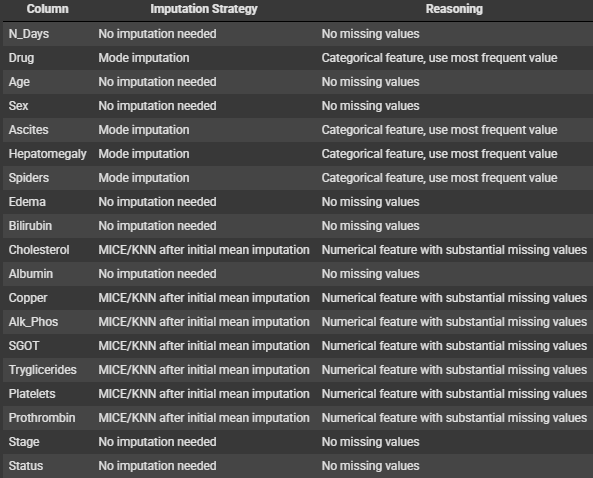



Pre-processing data

In [116]:
# Just encoding

encoder = OrdinalEncoder(categories=[['N', 'S', 'Y']])

# Fit and transform the 'Edema' column
processable_data['Edema'] = encoder.fit_transform(processable_data[['Edema']])
td_copy['Edema'] = encoder.transform(td_copy[['Edema']])




In [117]:
# Performing median imputation for low missing value percentages Prothrombin and Platelets

mean_impute_candidates = ['Platelets', 'Prothrombin']

for column in mean_impute_candidates:
    median_value = processable_data[column].median()

    # Impute missing values with the mean
    processable_data[column] = processable_data[column].fillna(median_value)
    td_copy[column] = td_copy[column].fillna(median_value)

In [118]:
processable_data['Status'].unique() , processable_data['Sex'].unique()

(array(['C', 'D', 'CL'], dtype=object), array(['F', 'M'], dtype=object))

In [120]:
processable_data['Ascites'].unique() , processable_data['Hepatomegaly'].unique() , processable_data['Spiders'].unique()

(array(['N', nan, 'Y'], dtype=object),
 array(['N', 'Y', nan], dtype=object),
 array(['N', nan, 'Y'], dtype=object))

In [119]:
processable_data.head(2)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1702.0,Placebo,18806.0,F,N,N,N,0.0,0.6,310.0,3.85,58.0,4332.0,43.40,112.0,273.0,10.6,3.0,C
1,2157.0,Placebo,22646.0,F,N,Y,N,0.0,0.8,255.0,4.14,15.0,1758.0,106.95,172.0,514.0,10.0,3.0,C


In [121]:
# Encode 'Sex' column
processable_data['Sex'] = processable_data['Sex'].map({'M': 0, 'F': 1})
td_copy['Sex'] = td_copy['Sex'].map({'M': 0, 'F': 1})

# Encode 'Drug'
processable_data['Drug'] = processable_data['Drug'].astype('category').cat.codes   # this assigns unique numerical code to each distinct category
td_copy['Drug'] = td_copy['Drug'].astype('category').cat.codes

# Encode 'Status'
processable_data['Status'] = processable_data['Status'].map({'C': 0, 'D': 1, 'CL': 2})
# test data has no status - to be predicted



In [122]:
# Encode 'Ascites'
processable_data['Ascites'] = processable_data['Ascites'].map({'N': 0, 'Y': 1, np.nan: 2})
td_copy['Ascites'] = td_copy['Ascites'].map({'N': 0, 'Y': 1, np.nan: 2})

# Encode 'Hepatomegaly'
processable_data['Hepatomegaly'] = processable_data['Hepatomegaly'].map({'N': 0, 'Y': 1, np.nan: 2})
td_copy['Hepatomegaly'] = td_copy['Hepatomegaly'].map({'N': 0, 'Y': 1, np.nan: 2})

# Encode 'Spiders'
processable_data['Spiders'] = processable_data['Spiders'].map({'N': 0, 'Y': 1, np.nan: 2})
td_copy['Spiders'] = td_copy['Spiders'].map({'N': 0, 'Y': 1, np.nan: 2})


In [123]:
# Drug, Ascites, Hepatomegaly, Spiders - Using MICE ( IterativeImputer with logistic regression)
# idea is to use ordinal encoder > do mice > post mice encoding
categorical_cols = ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders']

# # encoding the values before applying
# X_encc= processable_data.drop(columns=['Stage'])
# y_encc = processable_data['Stage']
# loo_encoder = LeaveOneOutEncoder(cols=categorical_cols)
# X_encc_encoded = loo_encoder.fit_transform(X_encc, y_encc)
# X_test_encoded = loo_encoder.transform(td_copy)

# # combine these two together
# processable_data = pd.concat([X_encc_encoded,y_encc.reset_index(drop = True)],axis=1)
# td_copy = X_test_encoded.copy()

In [124]:
processable_data.head(2)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1702.0,2,18806.0,1,0,0,0,0.0,0.6,310.0,3.85,58.0,4332.0,43.40,112.0,273.0,10.6,3.0,0
1,2157.0,2,22646.0,1,0,1,0,0.0,0.8,255.0,4.14,15.0,1758.0,106.95,172.0,514.0,10.0,3.0,0


In [125]:
td_copy.head(2)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2844.0,-1,19724.0,1,2,2,2,0.0,0.9,NaN,3.24,NaN,NaN,NaN,NaN,330.0,10.5,3.0
1,2504.0,0,23612.0,0,0,0,0,0.0,0.6,217.0,3.87,20.0,666.0,54.25,68.0,270.0,11.2,4.0


In [126]:
# ------------------------------------------------------------------------


# creating logistic regression estimator
estimator = ExtraTreesRegressor(random_state=40)

imputer = IterativeImputer(
    estimator=estimator,
    random_state=40
    )


# fiting for train and test
pd_imputed_categoricals = imputer.fit_transform(processable_data[categorical_cols])
td_imputed_categoricals = imputer.transform(td_copy[categorical_cols])

# updating our original dfs

processable_data[categorical_cols] = pd_imputed_categoricals
td_copy[categorical_cols] = td_imputed_categoricals




In [127]:
# Cholesterol, Copper, Alk_Phos, SGOT, Tryglicerides - Using IterativeImputer (e.g. with ExtraTrees)
num_cols = ['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides']

estimator = ExtraTreesRegressor(n_estimators=10,random_state=40)  # Using ExtraTreesRegressor

imputer = IterativeImputer(
    estimator=estimator,
    random_state=40
    )

# fitting

pd_etcls_imputed_numericals = imputer.fit_transform(processable_data[num_cols])
td_etcls_imputed_numericals = imputer.transform(td_copy[num_cols])

# update original df

processable_data[num_cols] = pd_etcls_imputed_numericals
td_copy[num_cols] = td_etcls_imputed_numericals


In [128]:
# after all imputation show the dfs

processable_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,1702.0,2.0,18806.0,1,0.0,0.0,0.0,0.0,0.6,310.0,3.85,58.0,4332.0,43.400,112.0,273.0,10.6,3.0,0
1,2157.0,2.0,22646.0,1,0.0,1.0,0.0,0.0,0.8,255.0,4.14,15.0,1758.0,106.950,172.0,514.0,10.0,3.0,0
2,1831.0,0.0,20483.0,1,0.0,0.0,0.0,0.0,0.8,256.0,3.85,20.0,646.0,57.000,84.0,204.0,9.9,3.0,0
3,971.0,-1.0,22646.0,1,2.0,2.0,2.0,0.0,3.0,603.3,3.03,68.6,1074.0,108.005,119.5,258.0,11.8,4.0,1
4,1368.0,-1.0,21915.0,1,2.0,2.0,2.0,0.0,0.8,603.3,3.94,68.6,1074.0,108.005,119.5,402.0,10.5,4.0,0


In [131]:
processable_data.isnull().sum() , td_copy.isnull().sum()

(N_Days           0
 Drug             0
 Age              0
 Sex              0
 Ascites          0
 Hepatomegaly     0
 Spiders          0
 Edema            0
 Bilirubin        0
 Cholesterol      0
 Albumin          0
 Copper           0
 Alk_Phos         0
 SGOT             0
 Tryglicerides    0
 Platelets        0
 Prothrombin      0
 Stage            0
 Status           0
 dtype: int64,
 N_Days           0
 Drug             0
 Age              0
 Sex              0
 Ascites          0
 Hepatomegaly     0
 Spiders          0
 Edema            0
 Bilirubin        0
 Cholesterol      0
 Albumin          0
 Copper           0
 Alk_Phos         0
 SGOT             0
 Tryglicerides    0
 Platelets        0
 Prothrombin      0
 Stage            0
 dtype: int64)

In [105]:
X_train = processable_data.drop('Status',axis=1)
y_train = processable_data['Status']

X_test = raw_data.drop('Status',axis=1)

In [106]:
X_train.shape , y_train.shape , X_test.shape

((15000, 18), (15000,), (15000, 18))

In [133]:

cols_to_scale = numerical_cols


# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled = scaler.transform(td_copy[cols_to_scale])

# Convert scaled arrays back to dataframes to maintain column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cols_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cols_to_scale, index=td_copy.index)

# Update td_copy with the transformed values
processable_data[cols_to_scale] = X_train_scaled_df
td_copy[cols_to_scale] = X_test_scaled_df

# # Now td_copy has the scaled values
# print(td_copy.head())


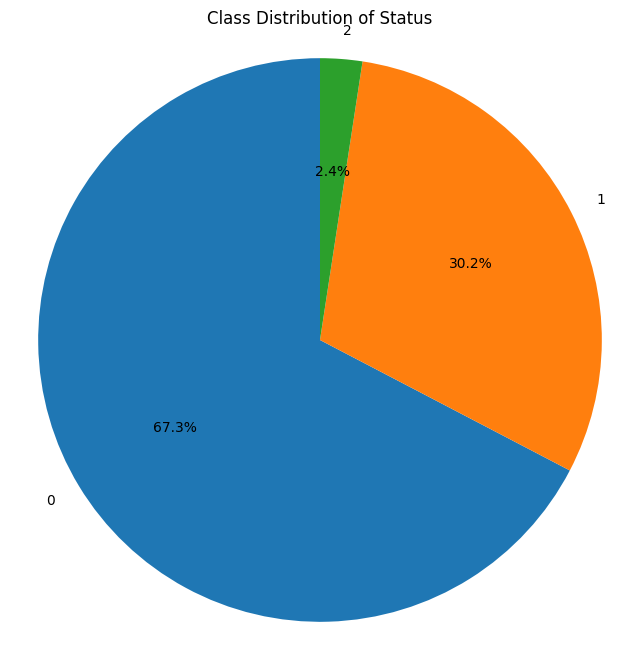

In [134]:
draw_class_balance_pie_chart(processable_data)


In [136]:

X_train = processable_data.drop('Status', axis=1)
y_train = processable_data['Status']
X_test = td_copy.copy()  # Use a copy to avoid modifying the original


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [100, 200, 300, 400],  # Adjust as needed
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostClassifier
model = CatBoostClassifier(random_seed=40, verbose=0) # verbose=0 for no training output

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model_cb = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


# Make predictions on the test set using the best model
y_pred = best_model_cb.predict(X_test)

#Further evaluation can be done here using metrics like accuracy, precision, recall, f1-score etc.
# Example:
# from sklearn.metrics import accuracy_score
# if y_test is not None: # Replace with your actual test labels
#    accuracy = accuracy_score(y_test, y_pred)
#    print(f"Accuracy: {accuracy}")


# Now you can use 'y_pred' for further analysis or submission.
y_pred


Best parameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [138]:
# Initialize CatBoostClassifier with the best parameters
best_model_cb = CatBoostClassifier(iterations=best_params['iterations'],
                                   depth=best_params['depth'],
                                   learning_rate=best_params['learning_rate'],
                                   l2_leaf_reg=best_params['l2_leaf_reg'],
                                   random_seed=40,
                                   loss_function='MultiClass', # Specify the loss function
                                   eval_metric='MultiClass') # Specify the evaluation metric


# Train the model with the best parameters
best_model_cb.fit(X_train, y_train, verbose=0)

# Predict probabilities on the test set
y_pred_proba = best_model_cb.predict_proba(X_test)

# Calculate log loss
logloss = log_loss(y_train, best_model_cb.predict_proba(X_train)) # Log loss on training data
print(f"Log Loss (training data) CatBoost: {logloss}")

Log Loss (training data): 0.3235150754228199


In [139]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.5 MB/s eta 0:00:00


In [140]:
# prompt: can you optimise using optuna

import optuna
from sklearn.metrics import log_loss

def objective(trial):
    # Define the hyperparameter search space
    iterations = trial.suggest_int('iterations', 100, 500)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.2)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10)

    # Initialize CatBoostClassifier with suggested hyperparameters
    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=40,
        loss_function='MultiClass',  # Specify the loss function
        eval_metric='MultiClass',  # Specify the evaluation metric
        verbose=0  # Suppress training output
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities on the training data
    y_pred_proba = model.predict_proba(X_train)

    # Calculate log loss and return it as the objective value
    logloss = log_loss(y_train, y_pred_proba)
    return logloss

# Create an Optuna study
study = optuna.create_study(direction='minimize')  # Minimize log loss

# Run the optimization
study.optimize(objective, n_trials=100) # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train a model with the best hyperparameters
best_model_cb = CatBoostClassifier(**best_params, random_seed=40, verbose=0, loss_function='MultiClass', eval_metric='MultiClass')
best_model_cb.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = best_model_cb.predict_proba(X_test)

# Calculate log loss on training data for the best model
logloss = log_loss(y_train, best_model_cb.predict_proba(X_train))
print(f"Log Loss (training data) CatBoost (best model): {logloss}")


[I 2025-04-20 03:26:25,414] A new study created in memory with name: no-name-c07e607c-7959-410f-897e-4b1d6e7ca94c
[I 2025-04-20 03:26:32,865] Trial 0 finished with value: 0.24590932837492735 and parameters: {'iterations': 271, 'depth': 7, 'learning_rate': 0.18153064977682526, 'l2_leaf_reg': 3}. Best is trial 0 with value: 0.24590932837492735.
[I 2025-04-20 03:26:43,937] Trial 1 finished with value: 0.29872063044228414 and parameters: {'iterations': 123, 'depth': 9, 'learning_rate': 0.13410613782697495, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.24590932837492735.
[I 2025-04-20 03:26:49,922] Trial 2 finished with value: 0.3524823044464796 and parameters: {'iterations': 175, 'depth': 7, 'learning_rate': 0.07250929205044458, 'l2_leaf_reg': 6}. Best is trial 0 with value: 0.24590932837492735.
[I 2025-04-20 03:27:09,744] Trial 3 finished with value: 0.30714805999360045 and parameters: {'iterations': 265, 'depth': 9, 'learning_rate': 0.03294922974617491, 'l2_leaf_reg': 1}. Best is tria

Best parameters: {'iterations': 496, 'depth': 10, 'learning_rate': 0.19619397284253198, 'l2_leaf_reg': 1}
Log Loss (training data) CatBoost (best model): 0.035216877941286764


In [142]:
# prompt: can you create the model using Best parameters: {'iterations': 496, 'depth': 10, 'learning_rate': 0.19619397284253198, 'l2_leaf_reg': 1} from last cell and report the logloss . you have test in td_copy

# Initialize CatBoostClassifier with the best parameters from the previous cell
best_model_cb = CatBoostClassifier(iterations=496,
                                   depth=10,
                                   learning_rate=0.19619397284253198,
                                   l2_leaf_reg=1,
                                   random_seed=40,
                                   loss_function='MultiClass',
                                   eval_metric='MultiClass',
                                   verbose=0)

# Train the model
best_model_cb.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = best_model_cb.predict_proba(X_test)

# Calculate log loss on the test set (assuming you have y_test)
# If you don't have y_test, calculate log loss on training data as a proxy.
logloss = log_loss(y_train, best_model_cb.predict_proba(X_train))
print(f"Log Loss (training data): {logloss}")


Log Loss (training data): 0.035216877941286764


In [ ]:
def create_submission_file(y_pred_proba,X_test,model):
  submission_df = pd.DataFrame(y_pred_proba, columns=['Status_C', 'Status_CL','Status_D'])

  # Concatenate the 'id' column from X_test to the predictions DataFrame
  submission_df['id'] = X_test['id'].values

  # Reorder columns to have 'id' as the first column
  submission_df = submission_df[['id', 'Status_C', 'Status_CL','Status_D']]

  # Display the first few rows of the submission DataFrame
  print(submission_df.head())

  # Save the submission file
  submission_df.to_csv(f'submission_{model}.csv', index=False)

Trying out lightGBM